In [12]:
#= This line adds functions to take
   an AR(2) model for US inflation
=#

using DataFrames
include("lag0.jl")
include("stability.jl")
include("iwpq.jl")

#load inflation datatable
data=readtable(".\\ch2_data\\dataUS.csv", header=false)
N=size(data, 2)
L=2 # number of lags in VAR
Y=data
Y=convert(Array, Y) # change "DataFrame type Y to array type Y"
X=[ones(size(Y,1),1) lag0(Y,1) lag0(Y,2)]

# # Way of converting DataArray to Array
# x1=eltype(Float64)[df[i,1] for i in [1:size(df,1)]]
# x2=eltype(Float64)[df[i,2] for i in [1:size(df,1)]]
# x3=eltype(Float64)[df[i,3] for i in [1:size(df,1)]]
# xx=[x1 x2 x3]
# X=[ones(T,1) lag0(xx,1) lag0(xx,2)]

# Remove missing obs.
Y=Y[3:end,:]
X=X[3:end,:]
T=size(X,1)

# compute standard deviation of each series residual via an ols
# regression to be used in setting the prior
# first variable
y=Y[:,1]
x=X[:, 1:2]
# in Julia, need to provide "type"
b0=inv(x'*x)*(x'*y)
#std of residual standard error second variable
s1=sqrt(((y-x*b0)'*(y-x*b0))/(size(y,1)-2))
s1=maximum(s1)

# second variable
y=Y[:, 2]
z=[true;false;true;false;false;false;false;false;false]
x=X[: , z]
b0=inv(x'*x)*(x'*y)
s2=sqrt(((y-x*b0)'*(y-x*b0))/(size(y,1)-2))
s2=maximum(s2)

# third variable
y=Y[:,3]
z=[true;false;false;true;false;false;false;false;false]
x=X[:,z]
b0=inv(x'*x)*(x'*y)
s3=sqrt(((y-x*b0)'*(y-x*b0))/(size(y,1)-2))
s3=maximum(s3)

#fourth variable
y=Y[:,4]
z=[true;false;false;false;true;false;false;false;false]
x=X[:,z]
b0=inv(x'*x)*(x'*y)
s4=sqrt(((y-x*b0)'*(y-x*b0))/(size(y,1)-2))
s4=maximum(s4)

#parameters to control the prior
lamda1=0.1     # tightness prior on the AR coefficients
lamda3=0.05   # tightness of prior on higher lags
lamda4=1        # tightness of prior on the constant term

# specify the prior mean of the coefficients of the Two equations of the VAR
B0=zeros((N*L+1), N)
for i=1:N
  B0[i+1,i]=0.95
end

B0=vec(B0)

# Specify the prior variance of vec(B)
H=eye(N*(N*L+1), N*(N*L+1))
#small for coefficients we want close to zero
H[3,3]=1e-9
H[4,4]=1e-9
H[5,5]=1e-9
H[7,7]=1e-9
H[8,8]=1e-9
H[9,9]=1e-9
#for others like the normal conjugate prior
#ist equation
H[1,1]=(s1*lamda4)^2
H[2,2]=(lamda1)^2
H[6,6]=(lamda1/(2^lamda3))^2
#second equation
H[10,10]=(s2*lamda4)^2
H[11,11]=((s2*lamda1)/s1)^2
H[12,12]=(lamda1)^2
H[13,13]=((s2*lamda1)/s3)^2
H[14,14]=((s2*lamda1)/s4)^2
H[15,15]=((s2*lamda1)/(s1*(2^lamda3)))^2
H[16,16]=(lamda1/(2^lamda3))^2
H[17,17]=((s2*lamda1)/(s3*(2^lamda3)))^2
H[18,18]=((s2*lamda1)/(s4*(2^lamda3)))^2
#third equation
H[19,19]=(s3*lamda4)^2
H[20,20]=((s3*lamda1)/s1)^2
H[21,21]=((s3*lamda1)/s2)^2
H[22,22]=(lamda1)^2
H[23,23]=((s3*lamda1)/s4)^2
H[24,24]=((s3*lamda1)/(s1*(2^lamda3)))^2
H[25,25]=((s3*lamda1)/(s2*(2^lamda3)))^2
H[26,26]=(lamda1/(2^lamda3))^2
H[27,27]=((s3*lamda1)/(s4*(2^lamda3)))^2
#fourth equation
H[28,28]=(s4*lamda4)^2
H[29,29]=((s4*lamda1)/s1)^2
H[30,30]=((s4*lamda1)/s2)^2
H[31,31]=((s4*lamda1)/s3)^2
H[32,32]=(lamda1)^2
H[33,33]=((s4*lamda1)/(s1*(2^lamda3)))^2
H[34,34]=((s4*lamda1)/(s2*(2^lamda3)))^2
H[35,35]=((s4*lamda1)/(s3*(2^lamda3)))^2
H[36,36]=(lamda1/(2^lamda3))^2


# prior scale matrix for sigma the VAR covariance
S=eye(N)
# prior degrees of freedom
alpha=N+1

# starting values for the Gibbs sampling algorithm
Sigma=eye(N)
betaols=vec(inv(X'*X)*(X'*Y))

Reps=40000
burn=30000

# Still wondering how to express in julia equivalently to x=[ ] in Matlab
# "58" = "60"-"3"+1
out1=zeros(58,1) # will store IRF of R
out2=zeros(58,1) # will store IRF of GB
out3=zeros(58,1) # will store IRF of U
out4=zeros(58,1) # will store IRF of P

i=1
for j in 1:Reps
  # step 1 draw the VAR coefficients
  M=inv(inv(H)+kron(inv(Sigma), X'*X))*(inv(H)*B0+kron(inv(Sigma), X'*X)*betaols)
  V=inv(inv(H)+kron(inv(Sigma), X'*X))
  # check for stability of the VAR
  check=-1
  while check<0
    bbeta=M+(randn(1,N*(N*L+1))*chol(V))' # beta is a generic funtion, thus name need to be changed
    CH=stability(bbeta,N,L)
    if CH==0
      check=10
    end
  end
  # draw sigma from the IW distribution
  ee=Y-X*reshape(bbeta, N*L+1, N)
  # scale matrix
  sscale=ee'*ee+S #scale is a generic method
  Sigma=IWPQ(T+alpha,inv(sscale))
  if j>burn
    # impulse response using a cholesky decomposition
    A0=chol(Sigma)
    v=zeros(60,N)
    v[L+1,2]=-1 #shock the government bondyield
    yhat=zeros(60,N)
    for i in 3:60
      yhat[i,:]=[0 yhat[i-1,:] yhat[i-2,:]]*reshape(bbeta,N*L+1,N)+v[i,:]*A0
    end
    out1=[out1 yhat[3:end,1]]
    # inital dimension of "out1" shoud report back
    # to the place where "out1" is first defined
    out2=[out2 yhat[3:end,2]]
    out3=[out3 yhat[3:end,3]]
    out4=[out4 yhat[3:end,4]]
  end
end

# calculation of percentile for each output
out1=out1[:,2:end]
out2=out2[:,2:end]
out3=out3[:,2:end]
out4=out4[:,2:end]

# number of percentiles, 50, 16, 84
nper=3
qout1=zeros(58,nper)
qout2=zeros(58,nper)
qout3=zeros(58,nper)
qout4=zeros(58,nper)

# "vec" is convert an array to a vector
for i in 1:58
  qout1[i,1]=quantile(vec(out1[i,:]), 50/100)
  qout2[i,1]=quantile(vec(out2[i,:]), 50/100)
  qout3[i,1]=quantile(vec(out3[i,:]), 50/100)
  qout4[i,1]=quantile(vec(out4[i,:]), 50/100)
end

for i in 1:58
  qout1[i,2]=quantile(vec(out1[i,:]), 16/100)
  qout2[i,2]=quantile(vec(out2[i,:]), 16/100)
  qout3[i,2]=quantile(vec(out3[i,:]), 16/100)
  qout4[i,2]=quantile(vec(out4[i,:]), 16/100)
end

for i in 1:58
  qout1[i,3]=quantile(vec(out1[i,:]), 84/100)
  qout2[i,3]=quantile(vec(out2[i,:]), 84/100)
  qout3[i,3]=quantile(vec(out3[i,:]), 84/100)
  qout4[i,3]=quantile(vec(out4[i,:]), 84/100)
end


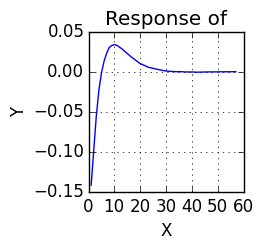

PyObject <matplotlib.text.Text object at 0x0000000037DE0CC0>

In [14]:

#=
Now draw some graphs using those results
=#
using PyPlot
fig=figure("Respons of ", figsize=(2,2))
ax=axes()
h=PyPlot.plt.plot(range(1, size(qout4,1)-1), qout4[2:end,1])
grid("on")
xlabel("X")
ylabel("Y")
title("Response of ")
